In [56]:
from datasets import load_dataset

# 添加 trust_remote_code=True 参数
# 指定文件
data_files = {
    "train": "train_data.csv",
    "test": "test_data.csv",
    "validation":"test_data.csv"
}

# 加载数据
dataset= load_dataset("csv", data_files=data_files)


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [158]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
def load_data(train_path, test_path):
    """
    加载训练集和测试集数据，并返回目标变量和特征。
    """
    train_data = pd.read_csv(train_path)
    train_cnt = train_data['cnt'].values # 提取目标变量
    train_features = train_data.iloc[:, 1:]  # 提取特征列

    test_data = pd.read_csv(test_path)
    test_cnt = test_data['cnt'].values  # 提取目标变量
    test_features = test_data.iloc[:, 1:]  # 提取特征列
    
    return train_features, train_cnt, test_features, test_cnt

def create_sequences(features, targets, input_length, output_length):
    """
    根据滑动窗口生成输入序列和目标序列。
    """
    X, y = [], []
    for i in range(len(targets) - input_length - output_length + 1):
        X.append(features[i:i + input_length+ output_length].values)
        y.append(targets[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

# 加载数据
train_features, train_cnt, test_features, test_cnt = load_data('train_data.csv', 'test_data.csv')

# 定义滑动窗口长度
input_length = 96
output_length_short = 96  # 短期预测
output_length_long = 240  # 长期预测

# 生成训练数据和测试数据
X_train, y_train = create_sequences(train_features, train_cnt, input_length, output_length_short)
X_test, y_test = create_sequences(test_features, test_cnt, input_length, output_length_short)

# 检查生成数据形状
print("训练集输入形状:", X_train.shape)
print("训练集目标形状:", y_train.shape)
print("测试集（短期）输入形状:", X_test.shape)
print("测试集（短期）目标形状:", y_test.shape)



训练集输入形状: (15025, 192, 16)
训练集目标形状: (15025, 96)
测试集（短期）输入形状: (1969, 192, 16)
测试集（短期）目标形状: (1969, 96)


In [185]:
X_train[:,:,-1].shape

(15025, 192)

In [228]:
import numpy as np
import pandas as pd
from datasets import Dataset
from datasets import Dataset, Value, Sequence, Features

data = {
    'start': pd.to_datetime(X_train[:,0,0]),
    'target':X_train[:,:,-1] ,  # Sequence of float32
    "feat_static_cat": [[0] for _ in range(X_train.shape[0])],
    "feat_dynamic_real": X_train[:,:,1:-1],    # 动态实值特征
    "item_id": [f"T{i}" for i in range(X_train.shape[0])],    
}
               
features = Features({
    'start': Value(dtype='timestamp[s]'),
    'target': Sequence(feature=Value(dtype='float32')),
    'feat_static_cat': Sequence(feature=Value(dtype='uint64')),
    'feat_dynamic_real': Sequence(feature=Sequence(feature=Value(dtype='float32'))),
    'item_id': Value(dtype='string'),
})
# 转换为 Hugging Face 数据集
train_dataset = Dataset.from_dict(data, features=features)




In [248]:
data = {
    'start': pd.to_datetime(X_test[:,0,0]),
    'target':X_test[:,:,-1] ,  # Sequence of float32
    "feat_static_cat": [[0] for _ in range(X_test.shape[0])],
    "feat_dynamic_real": X_test[:,:,1:-1],    # 动态实值特征
    "item_id": [f"T{i}" for i in range(X_test.shape[0])],    
}
               
features = Features({
    'start': Value(dtype='timestamp[s]'),
    'target': Sequence(feature=Value(dtype='float32')),
    'feat_static_cat': Sequence(feature=Value(dtype='uint64')),
    'feat_dynamic_real': Sequence(feature=Sequence(feature=Value(dtype='float32'))),
    'item_id': Value(dtype='string'),
})
# 转换为 Hugging Face 数据集
test_dataset = Dataset.from_dict(data, features=features)

In [204]:
print(train_dataset.features)

{'start': Value(dtype='timestamp[s]', id=None), 'target': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'feat_static_cat': Sequence(feature=Value(dtype='uint64', id=None), length=-1, id=None), 'feat_dynamic_real': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), 'item_id': Value(dtype='string', id=None)}


In [230]:
freq = "h"

In [231]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [252]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [233]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [234]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)


[<function hour_of_day at 0x0000028047319040>, <function day_of_week at 0x0000028047319160>, <function day_of_month at 0x0000028047319280>, <function day_of_year at 0x00000280473193A0>]


In [235]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=96,
    # context length:
    context_length=96,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [236]:
model.config.distribution_output


'student_t'

In [237]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [238]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [239]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [240]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [241]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [250]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [243]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 817, 5]) torch.FloatTensor
past_values torch.Size([256, 817]) torch.FloatTensor
past_observed_mask torch.Size([256, 817]) torch.FloatTensor
future_time_features torch.Size([256, 96, 5]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.IntTensor
future_values torch.Size([256, 96]) torch.FloatTensor
future_observed_mask torch.Size([256, 96]) torch.FloatTensor


In [244]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [245]:
print("Loss:", outputs.loss.item())

Loss: 7.401227951049805


In [246]:

from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(15):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

7.476379871368408
6.556905746459961
6.249591827392578
5.997716903686523
5.880639553070068
5.814939975738525
5.557605743408203
5.675060272216797
5.640087127685547
5.5290985107421875
5.127668857574463
5.110413551330566
5.320912837982178
5.167761325836182
5.156444072723389
5.177727222442627
5.091916084289551
5.093942165374756
5.042773246765137
5.100403308868408
5.217807769775391
5.177376747131348
5.207468509674072
5.173888683319092
5.211376190185547
5.492410182952881
5.367838382720947
5.46697998046875
5.220862865447998
5.326353073120117
5.449278354644775
5.3105082511901855
5.213554859161377
5.106534004211426
5.162262439727783
5.129844665527344
5.171655178070068
5.194084644317627
5.132523059844971
5.216233730316162


In [253]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [254]:
forecasts[0].shape


(64, 100, 96)

In [255]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)


(1969, 100, 96)


In [257]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-96]
    ground_truth = ts["target"][-96:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])

In [258]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.4802692100542387


In [259]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.5749989043697493


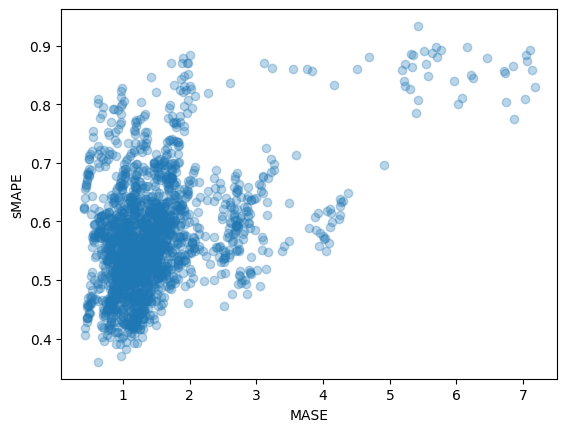

In [260]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [281]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-96:], 
        test_dataset[ts_index]["target"][-96:],
        label="actual",
    )

    plt.plot(
        index[-96:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-96:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.savefig("short_term_prediction_transformer.png", dpi=300)
    plt.show()

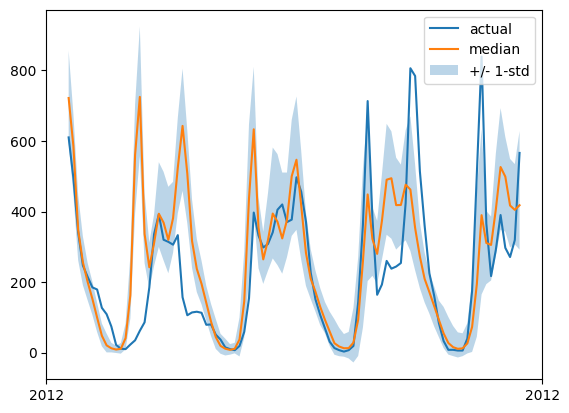

In [282]:
plot(33)

In [278]:
truth=X_test[:,:-96,-1]

In [279]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(forecast_median, truth)
mae = mean_absolute_error(forecast_median, truth)

In [280]:
print(mae,mse)

103.8496234650393 24732.753973314655
